In [1]:
import parselmouth as pm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#The Italian vowels
    vowels = ['a', 'ɛ', 'e', 'i', 'o', 'ɔ', 'u']
def normalizeSound(sound):
#Transforms the audio file to make it more processable
    sound = sound.convert_to_mono()
    #Trim silences parameters
    trimDuration = 0.05
    onlyAtStartAndEnd = 0
    minPitch = 100
    timeStep = 0
    silenceThreshold = -2
    minSilenceDuration = 0.01
    minSoundingDuration = 0.01
    tg = 0
    trimLabel = "silence"
    sound = pm.praat.call(sound, "Trim silences",trimDuration, onlyAtStartAndEnd, minPitch, timeStep, silenceThreshold, 
                          minSilenceDuration,minSoundingDuration, tg, trimLabel)
    return sound

def getFeatureVect(sound):
    start_value=0.2
    mid_value=0.5
    end_value=0.8

    start_time=sound.get_start_time()
    end_time=sound.get_end_time()
    total_time=end_time-start_time;
    
    formant_burg=sound.to_formant_burg();
    #Values are taken in different times for averaging them afterwards
    #Get F1
    f1_start=formant_burg.get_value_at_time(1,start_time+(total_time*start_value))
    f1_mid=formant_burg.get_value_at_time(1,start_time+(total_time*mid_value))
    f1_end=formant_burg.get_value_at_time(1,start_time+(total_time*end_value))
    #Get F2
    f2_start=formant_burg.get_value_at_time(2,start_time+(total_time*start_value))
    f2_mid=formant_burg.get_value_at_time(2,start_time+(total_time*mid_value))
    f2_end=formant_burg.get_value_at_time(2,start_time+(total_time*end_value))
    
    return np.array([f1_start,f1_mid,f1_end,f2_start,f2_mid,f2_end])

def plotFormants(X, vowels): 
#X is the sequence of feature vectors
#vowels is the label of each feature vector
#Plots the vowels on the Formants graph

    colors=['red','blue','orange','brown','violet','green','turquoise','black','grey','yellow','purple']
    
    plt.figure(dpi=110)
    plt.ylabel("F1")
    plt.xlabel("F2")
    
    #Calculates an average of the F1 and F2 values
    F1_start=X[::,0]
    F1_mid=X[::,1]
    F1_end=X[::,2]
    F2_start=X[::,3]
    F2_mid=X[::,4]
    F2_end=X[::,5]
    F2_avg=(F2_start+F2_mid+F2_end)/3;
    F1_avg=(F1_start+F1_mid+F1_end)/3;
    
    #Sets the size of the graph accordingly
    plt.xlim([np.max(F2_avg), np.min(F2_avg)])
    plt.ylim([np.max(F1_avg), np.min(F1_avg)])
    
    #Annotates the vowels
    i=0
    lastVowel=vowels[0]
    colorIndex=0
    for vowel in vowels:
        if(vowel!=lastVowel):
            colorIndex=colorIndex+1
        lastVowel=vowel
        plt.annotate(vowel, (F2_avg[i], F1_avg[i]),color=colors[colorIndex])
        i=i+1
    plt.grid()
    plt.show()
    
def fillDataset(dataset_dir):
    X = []
    Y = []
    for vowel in vowels:
        theresMore = True
        i = 1
        while theresMore:
            #Each file in the directory is named accordingly
            #example: "e (2).wav"
            path = dataset_dir+"/"+vowel+" ("+str(i)+").wav"
            try:
                pureSnd = pm.Sound(path)
                snd = normalizeSound(pureSnd)
                vect = getFeatureVect(snd)
                X.append(vect)
                Y.append(vowel)
                i = i + 1
            except pm.PraatError:
                theresMore=False
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [3]:
dataset_dir="data_set"
X, Y = fillDataset(dataset_dir)
#For this test, 20 audios per vowel were used

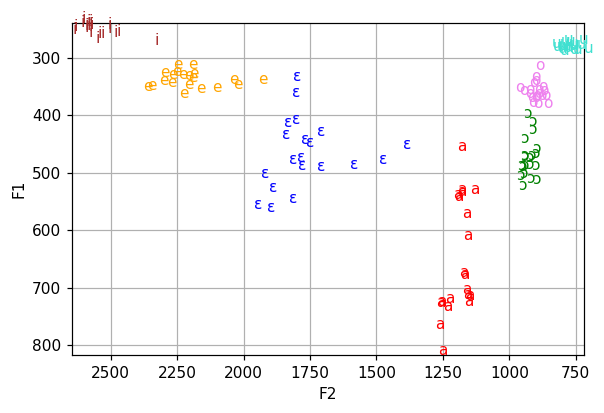

In [4]:
#Let's plot the vowels
plotFormants(X,Y)

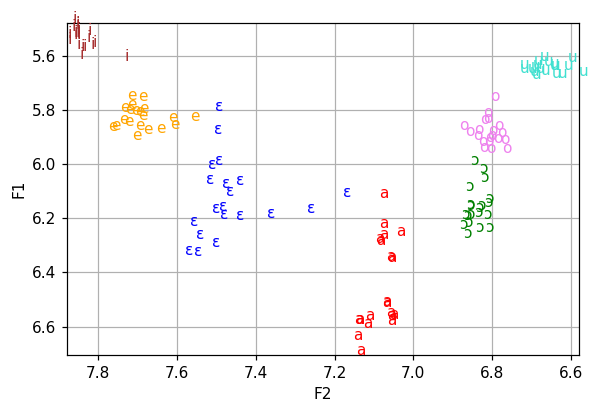

In [5]:
#Applies a Logarithmic transformation for more clearness and better performance
X_trans=np.log(X)
plotFormants(X_trans,Y)

In [6]:
testSize=35

X_train, X_test, Y_train, Y_test=train_test_split(X_trans, Y,test_size=testSize);
#SVM
model=SVC(kernel='poly')
model.fit(X_train, Y_train)
predicted_values = model.predict(X_test)
acc=accuracy_score(predicted_values, Y_test)
print("Accuracy reached:", acc)

Accuracy reached: 1.0
